#Heart attack prediction 

### This markdown is for code for the datascience exam project 

Data analysis of Heart Attack Prediction dataset from Kaggle. Random forest classifiers.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import pickle

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score




In [19]:
# Load data
DF = pd.read_csv("heart.csv")

print(DF)


     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  

Take a look at the data

In [20]:
print(DF["sex"].value_counts())
print(DF["output"].value_counts())


1    207
0     96
Name: sex, dtype: int64
1    165
0    138
Name: output, dtype: int64


In [21]:
# Checking if there are any NAs
DF.isnull().values.any()

False

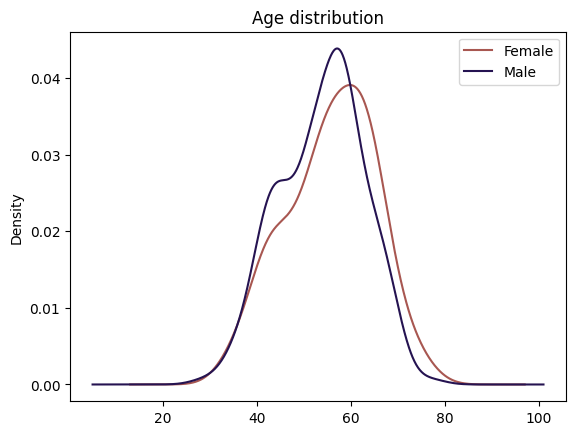

In [22]:

DF.groupby('sex').age.plot(kind='kde' ,style= {'1':'#251351', '0':'#A85751'})
plt.title("Age distribution")
plt.legend(["Female", "Male"])




In [23]:
meanage = DF["age"].mean()
sdage = DF["age"].std()

print(meanage, sdage)

54.366336633663366 9.082100989837857


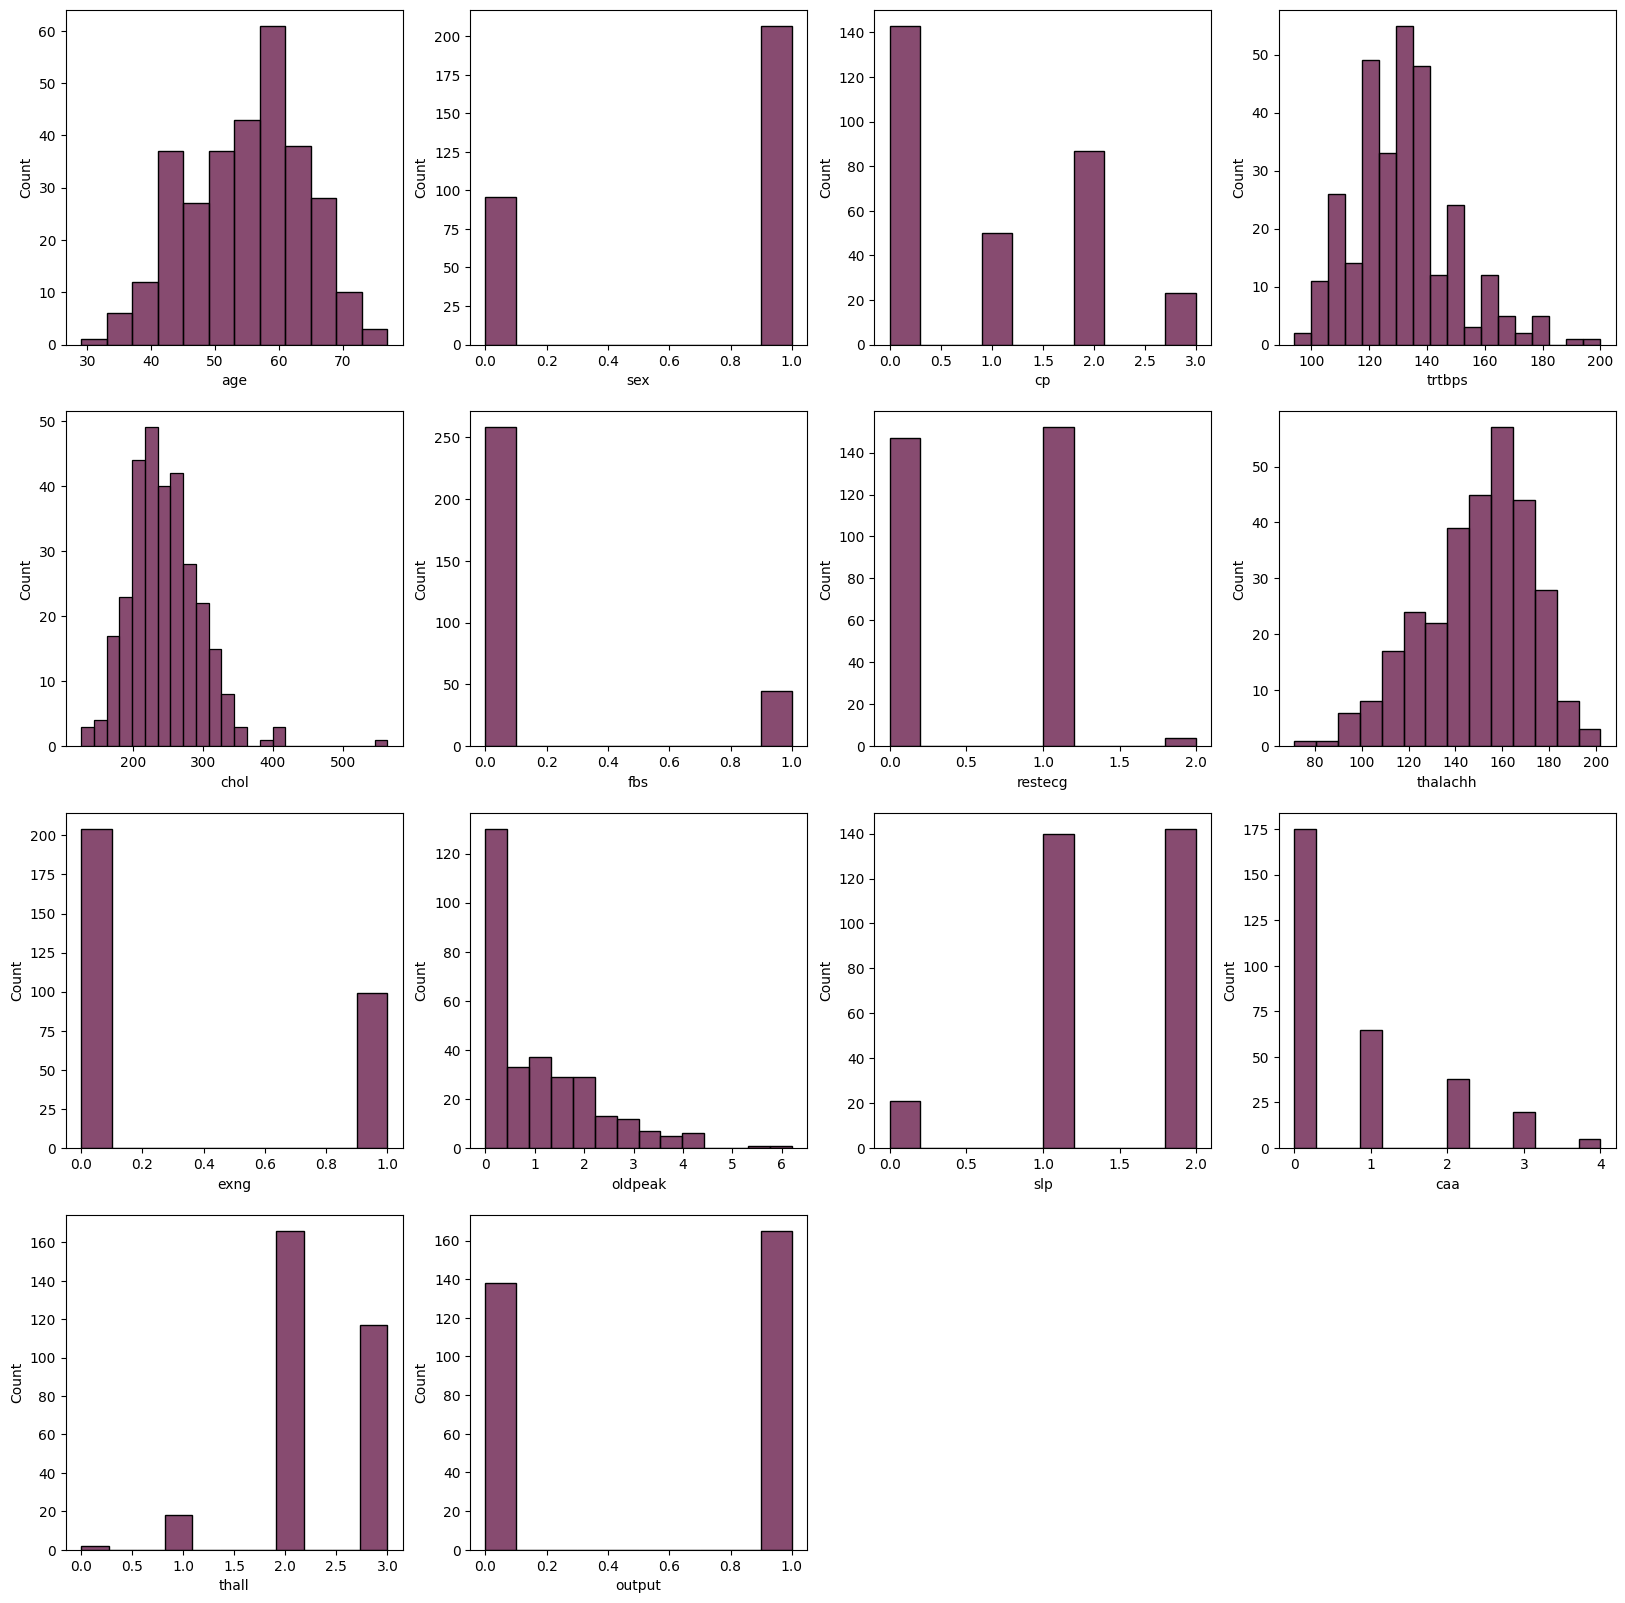

In [24]:
plt.figure(figsize = (20, 20))

for i in range(len(DF.columns)):
    plt.subplot(4, 4, i+1)
    sns.histplot(DF.iloc[:, i], color = '#5F0F40')

Correlation matrix

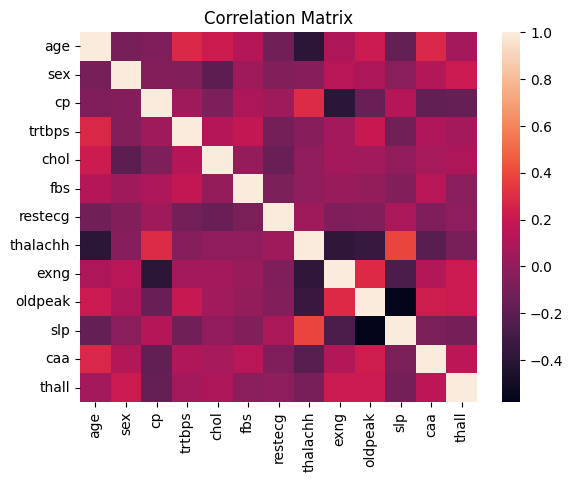

In [25]:
# Make a subset of the data to keep out the output variable
DF_nop = DF.iloc[:, :13]

# Correlation matrix / heatmap
corr_matrix = sns.heatmap(DF_nop.corr(),
                xticklabels=DF_nop.columns,
                yticklabels=DF_nop.columns)

corr_matrix.set_title('Correlation Matrix')
plt.show()

Prepping for first model

In [26]:
#Choose what variables you want in x. : before comma means all rows, :13 after comma means all the 13 first columns

x = DF.iloc[:, :13]
x

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [27]:
# Taking a quick look at x and y values
x.values

array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [28]:
y = DF.iloc[:, -1]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 303, dtype: int64

In [29]:
y.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
# Split into train and testsets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [31]:
# Fit the model // train model1 on training data
RFmodel1 = RandomForestClassifier()
RFmodel1.fit(x_train, y_train)

RandomForestClassifier()

In [32]:
# Test Model1 
RFprediction1 = RFmodel1.predict(x_test)

In [33]:
target_names = ["Low risk", "High risk"]

In [34]:
# Model performance
print(classification_report(y_test, RFprediction1, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.786     0.733     0.759        30
   High risk      0.758     0.806     0.781        31

    accuracy                          0.770        61
   macro avg      0.772     0.770     0.770        61
weighted avg      0.771     0.770     0.770        61



Feature Importance of Random Forest model 1

In [35]:
# Fetch the variables which the model 'thinks' is best
pd.DataFrame(RFmodel1.feature_importances_, index=x_train.columns).sort_values(by=0, ascending=False)

,0
cp,0.171283
thalachh,0.129295
caa,0.105006
oldpeak,0.094079
exng,0.085087
age,0.083598
trtbps,0.077047
chol,0.074885
thall,0.062916
sex,0.044036


Build, train, test Model2 according to the feature importance output.

In [36]:
x2 = DF.iloc[:, [2, 4, 9, 11]]
x2

,cp,chol,oldpeak,caa
0,3,233,2.3,0
1,2,250,3.5,0
2,1,204,1.4,0
3,1,236,0.8,0
4,0,354,0.6,0
...,...,...,...,...
298,0,241,0.2,0
299,3,264,1.2,0
300,0,193,3.4,2
301,0,131,1.2,1


In [37]:
# Split into train and testsets
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y, test_size=0.2, random_state=1)

In [38]:
# Fit the model // train model2 on training data
RFmodel2 = RandomForestClassifier()
RFmodel2.fit(x2_train, y2_train)

# Test Model2 
RFprediction2 = RFmodel2.predict(x2_test)

# Model performance
print(classification_report(y2_test, RFprediction2, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.656     0.700     0.677        30
   High risk      0.690     0.645     0.667        31

    accuracy                          0.672        61
   macro avg      0.673     0.673     0.672        61
weighted avg      0.673     0.672     0.672        61



Model with all variables using XGBoost classifier

In [39]:
# Fit the model // train XGBmodel1 on training data
XGBmodel1 = XGBClassifier()
XGBmodel1.fit(x_train, y_train)

# Test model
XGBprediction1 = XGBmodel1.predict(x_test)

# Model performance
print(classification_report(y_test, XGBprediction1, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.840     0.700     0.764        30
   High risk      0.750     0.871     0.806        31

    accuracy                          0.787        61
   macro avg      0.795     0.785     0.785        61
weighted avg      0.794     0.787     0.785        61



Feature importance of XGBoost model1

In [40]:
pd.DataFrame(XGBmodel1.feature_importances_, index=x_train.columns).sort_values(by=0, ascending=False)

,0
cp,0.279542
exng,0.166955
caa,0.119970
oldpeak,0.074536
sex,0.070020
thall,0.061043
chol,0.037126
restecg,0.036797
thalachh,0.034991
fbs,0.034373


This is slightly different than the output of the feature importance for Random Forest model1.
We should keep in mind that the variables exng and cp are highly correlated and so is exng and oldpeak (see correlation matrix)

I will therefore make two models, one with exng and one with oldpeak, to see performs best.

Build XGBmodel2 that is trained on cp, exng, caa, sex, and thall

In [41]:

x3 = DF.iloc[:, [1, 2, 8, 11, 12]]
x3


,sex,cp,exng,caa,thall
0,1,3,0,0,1
1,1,2,0,0,2
2,0,1,0,0,2
3,1,1,0,0,2
4,0,0,1,0,2
...,...,...,...,...,...
298,0,0,1,0,3
299,1,3,0,0,3
300,1,0,0,2,3
301,1,0,1,1,3


In [42]:
# Split into train and testsets
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y, test_size=0.2, random_state=1)

In [43]:
# Fit the model // train XGBmodel3 on the variables cp, exng, and caa
XGBmodel2 = XGBClassifier()
XGBmodel2.fit(x3_train, y3_train)

# Test model
XGBprediction2 = XGBmodel2.predict(x3_test)

# Model performance
print(classification_report(y3_test, XGBprediction2, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.778     0.700     0.737        30
   High risk      0.735     0.806     0.769        31

    accuracy                          0.754        61
   macro avg      0.757     0.753     0.753        61
weighted avg      0.756     0.754     0.753        61



In [44]:
x4 = DF.iloc[:, [1, 2, 9, 11, 12]]  # sex, cp, oldpeak, caa, thall
x4

# Split into train and testsets
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y, test_size=0.2, random_state=1)

# Fit the model // train XGBmodel2 on the variables cp, oldpeak, and caa
XGBmodel3 = XGBClassifier()
XGBmodel3.fit(x4_train, y4_train)

# Test model
XGBprediction3 = XGBmodel3.predict(x4_test)

# Model performance
print(classification_report(y4_test, XGBprediction3, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.850     0.567     0.680        30
   High risk      0.683     0.903     0.778        31

    accuracy                          0.738        61
   macro avg      0.766     0.735     0.729        61
weighted avg      0.765     0.738     0.730        61



Finally, a Random Forest classifier model and a XGBoost classifier model based on risk factors in literature.


Build XGBmodel 4 

In [45]:
x5 = DF.iloc[:, [0, 1, 2, 3, 4]]

# Split into train and testsets
x5_train, x5_test, y5_train, y5_test = train_test_split(x5, y, test_size=0.2, random_state=1)

# Fit the model // train XGBmodel3 on the variables cp, exng, and caa
XGBmodel4 = XGBClassifier()
XGBmodel4.fit(x5_train, y5_train)

# Test model
XGBprediction4 = XGBmodel4.predict(x5_test)

# Model performance
print(classification_report(y5_test, XGBprediction4, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.700     0.700     0.700        30
   High risk      0.710     0.710     0.710        31

    accuracy                          0.705        61
   macro avg      0.705     0.705     0.705        61
weighted avg      0.705     0.705     0.705        61



Build RFmodel3

In [46]:
# Fit the model // train XGBmodel3 on the variables cp, exng, and caa
RFmodel3 = RandomForestClassifier()
RFmodel3.fit(x5_train, y5_train)

# Test model
RFprediction3 = RFmodel3.predict(x5_test)

# Model performance
print(classification_report(y5_test, RFprediction3, target_names= target_names, digits = 3))

              precision    recall  f1-score   support

    Low risk      0.710     0.733     0.721        30
   High risk      0.733     0.710     0.721        31

    accuracy                          0.721        61
   macro avg      0.722     0.722     0.721        61
weighted avg      0.722     0.721     0.721        61

